# Detecting Toxic Comments for the "Wikishop" Online Store

### Project Goal

The "Wikishop" online store is introducing a wiki-editing feature for product descriptions, allowing users to edit and comment on changes made by others. To prevent negative experiences due to toxic comments, the company requires a tool to automatically detect and flag negative or aggressive comments for moderation. The goal is to train a model that can classify comments as either toxic or neutral, with an F1 score of at least 0.7.

### Project Plan

1. **Data Loading and Preparation**:
   - Load the dataset and explore the data structure.
   - Clean and preprocess the text data to prepare it for model training (remove special characters, perform tokenization, etc.).
   - Address class imbalance if necessary.

2. **Model Training and Comparison**:
   - Apply a traditional approach using TF-IDF vectorization to create features and train multiple classification models, such as logistic regression and CatBoost.
   - Test an advanced model based on BERT for more accurate text analysis.
   - Tune the hyperparameters of each model and optimize them to measure the F1 score.

3. **Model Selection and Testing**:
   - Select the best model based on results and test it on a holdout sample.
   - Evaluate the model's stability and accuracy, documenting the achieved F1 score.

4. **Conclusion**:
   - Summarize findings and make recommendations for the future use of the model in the online store.

### Data Description

- **Data file**: `toxic_comments.csv`
- **Data fields**:
   - **text** — the user’s comment text.
   - **toxic** — the target label (toxicity marker), where `1` represents a toxic comment, and `0` represents a neutral comment.

## Data preparation

### Importing libraries 


In [5]:
pip install imbalanced-learn -q

Note: you may need to restart the kernel to use updated packages.


In [6]:
!pip install wordcloud -q


In [7]:
pip install torch -q

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install transformers -q

Note: you may need to restart the kernel to use updated packages.


In [9]:
!pip install catboost -q

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast
import transformers
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel
import sys
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm, notebook
import gc
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

### Reading csv file 

In [12]:
pth1_comments = 'toxic_comments.csv'
pth2_comments = '/datasets/toxic_comments.csv'

if os.path.exists(pth1_comments):
    df_comments = pd.read_csv(pth1_comments)
elif os.path.exists(pth2_comments):
    df_comments = pd.read_csv(pth2_comments)
else:
    print('Something is wrong with toxic_comments.csv')


In [13]:
df_comments.head(3)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0


In [14]:
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Now we exploring class imbalance

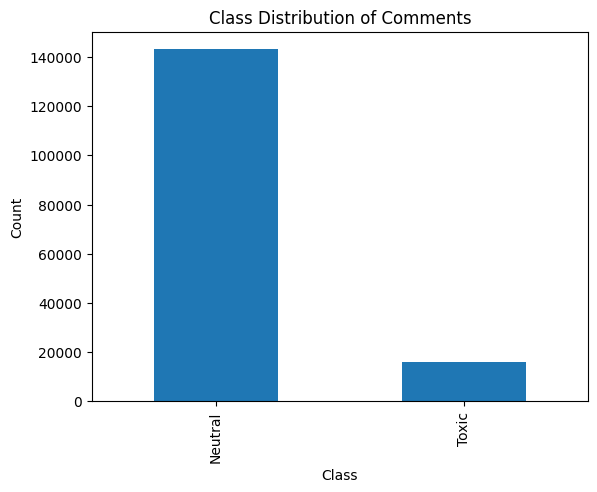

In [16]:
class_counts = df_comments['toxic'].value_counts()

class_counts.plot(kind='bar')
plt.title('Class Distribution of Comments')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Neutral', 'Toxic'])
plt.show()



- The dataset contains 159,291 entries across three columns.
- The format is correct.
- There are no missing values.
- The chart also shows that the number of neutral comments significantly exceeds the number of toxic ones. This imbalance may hinder model training, as it could lean toward the more frequent (neutral) class, resulting in lower accuracy on toxic comments.

The dataset contains a column named `Unnamed: 0`, which duplicates the index values. This column can be removed.

In [19]:
df_comments = df_comments.drop(columns = ['Unnamed: 0'])
df_comments.head(2)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0


To apply TF-IDF, we’ll take a sample of the data 20.000 records

In [21]:
df_comments = df_comments.sample(20000, random_state=12345).reset_index(drop=True)

Next we’ll perform text cleaning, lemmatization and removing of stop words

In [23]:
# load the spaCy model for lemmatization
nlp = spacy.load("en_core_web_sm")

# function for text cleaning
def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Z]', ' ', text.lower()).split())

def lemmatize_and_remove_stopwords(text):
    # Lemmatize the text and remove stop words using spaCy
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if token.lemma_ not in STOP_WORDS and token.lemma_.strip() != ''])

# apply text cleaning and lemmatization
df_comments['clear_text'] = df_comments['text'].apply(clear_text)
df_comments['lemmatized_text'] = df_comments['clear_text'].apply(lemmatize_and_remove_stopwords)

# display the difference between cleaned and original text
df_comments.head(5)

,text,toxic,clear_text,lemmatized_text
0,Expert Categorizers \n\nWhy is there no menti...,0,expert categorizers why is there no mention of...,expert categorizer mention fact nazi particula...
1,"""\n\n Noise \n\nfart* talk. """,1,noise fart talk,noise fart talk
2,"An indefinite block is appropriate, even for a...",0,an indefinite block is appropriate even for a ...,indefinite block appropriate minor infraction ...
3,I don't understand why we have a screenshot of...,0,i don t understand why we have a screenshot of...,I don t understand screenshot ap s gui ub remedy
4,"Hello! Some of the people, places or things yo...",0,hello some of the people places or things you ...,hello people place thing write article nikolas...


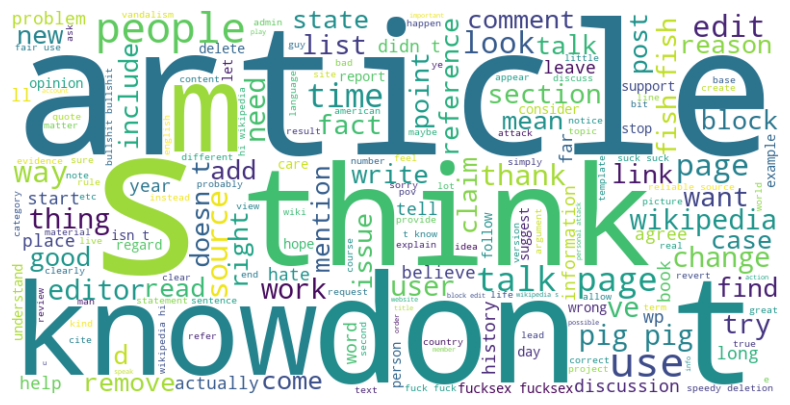

In [24]:
all_text = " ".join(df_comments['lemmatized_text'].dropna().values)

# generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Analyzing the word cloud, we can conclude that the most frequently occurring words are "article," "don’t know," and "think."

## Model training 

### Preparation and training using TF-IDF

In [28]:
# split features and target variables
features = df_comments['lemmatized_text']
target = df_comments['toxic']

# train-test split
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345, stratify=target)

# vectorization
vect = TfidfVectorizer()
features_train_tfidf = vect.fit_transform(features_train)
features_test_tfidf = vect.transform(features_test)

Now we proceed with training and testing logistic regression nad CatBoost model 

In [32]:
# define the parameter grid for C
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# initialize the Logistic Regression model
model_tfidf = LogisticRegression(class_weight='balanced', random_state=12345)

# set up GridSearchCV
grid_search = GridSearchCV(model_tfidf, param_grid, scoring='f1', cv=5)
grid_search.fit(features_train_tfidf, target_train)

# get the best model from grid search
best_model = grid_search.best_estimator_
best_C = grid_search.best_params_['C']
print("Best C:", best_C)

# make predictions with the best model
best_model_pred = best_model.predict(features_test_tfidf)
best_f1_score = f1_score(target_test, best_model_pred)

print("Optimized Logistic Regression F1 Score:", best_f1_score)



Best C: 10
Optimized Logistic Regression F1 Score: 0.7456647398843931


In [35]:
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    random_seed=12345,
    task_type="CPU", 
    verbose=100,
    early_stopping_rounds=50,
    auto_class_weights='Balanced' 
)
catboost_model.fit(features_train_tfidf, target_train)
catboost_pred = catboost_model.predict(features_test_tfidf)

# calculate F1 score for CatBoost
catboost_f1_score = f1_score(target_test, catboost_pred)
print("CatBoost F1 Score:", catboost_f1_score)

0:	learn: 0.6710898	total: 441ms	remaining: 3m 40s
100:	learn: 0.4081289	total: 16.8s	remaining: 1m 6s
200:	learn: 0.3401836	total: 32.8s	remaining: 48.8s
300:	learn: 0.2734271	total: 48.9s	remaining: 32.4s
400:	learn: 0.2303560	total: 1m 5s	remaining: 16.2s
499:	learn: 0.1989453	total: 1m 22s	remaining: 0us
CatBoost F1 Score: 0.7377521613832853


### Preparation and training using BERT

For bert lets take a sample of 2000 records 

In [39]:
df_sampled_bert = df_comments.sample(2000, random_state=12345).reset_index(drop=True)

In [41]:
# features and target
features = df_sampled_bert['lemmatized_text']
target = df_sampled_bert['toxic']

# Train-test split
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345, stratify=target)


tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")
model = AutoModel.from_pretrained("unitary/toxic-bert")

# df preparation
class ToxicDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=256):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        tokens = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return tokens['input_ids'].squeeze(0), tokens['attention_mask'].squeeze(0)

BATCH_SIZE = 64

train_dataset = ToxicDataset(features_train, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define num_workers based on whether CUDA is available
num_workers = 4 if torch.cuda.is_available() else 0

# Function to get embeddings
def get_embeddings(model, dataloader):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids, attention_mask = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            
            with torch.cuda.amp.autocast():  
                outputs = model(input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeddings)

            del input_ids, attention_mask, outputs
            gc.collect()

    return np.concatenate(embeddings)

# embeddings for the training set
embeddings_train = get_embeddings(model, train_dataloader)

# Apply SMOTE to the BERT embeddings to balance 
smote = SMOTE(random_state=42)
embeddings_train_resampled, target_train_resampled = smote.fit_resample(embeddings_train, target_train)


print("Original shape:", embeddings_train.shape)
print("Resampled shape:", embeddings_train_resampled.shape)
print("Resampled target distribution:", np.bincount(target_train_resampled))

# embeddings for the test set 
test_dataset = ToxicDataset(features_test, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=num_workers)

embeddings_test = get_embeddings(model, test_dataloader)
print("Test set embeddings shape:", embeddings_test.shape)



  0%|                                                    | 0/24 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  4%|█▊                                          | 1/24 [00:24<09:26, 24.63s/it]/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|███████████████████████████████████████████| 24/24 [08:51<00:00, 22.16s/it]
/opt/anaconda3/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workar

Original shape: (1500, 768)
Resampled shape: (2710, 768)
Resampled target distribution: [1355 1355]


  0%|                                                     | 0/8 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|█████████████████████████████████████████████| 8/8 [03:02<00:00, 22.85s/it]

Test set embeddings shape: (500, 768)


Now we proceed with training and testing logistic regression nad CatBoost model 

In [48]:
#logistic regression
clf_logistic = LogisticRegression(random_state=12345, solver='saga', class_weight='balanced', max_iter=1000)
clf_logistic.fit(embeddings_train_resampled, target_train_resampled)
pred = clf_logistic.predict(embeddings_test)

logistic_f1 = f1_score(target_test, pred)
print(f"Logistic Regression F1 Score: {logistic_f1:.2f}")



Logistic Regression F1 Score: 0.77


In [49]:
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    random_seed=12345,
    task_type="CPU", 
    verbose=100,
    early_stopping_rounds=50,
    auto_class_weights='Balanced' 
)
catboost_model.fit(embeddings_train_resampled, target_train_resampled)
catboost_pred = catboost_model.predict(embeddings_test)

# calculate F1 score for CatBoost
catboost_f1_score = f1_score(target_test, catboost_pred)
print("CatBoost F1 Score:", catboost_f1_score)

0:	learn: 0.5957525	total: 218ms	remaining: 1m 48s
100:	learn: 0.0151160	total: 10s	remaining: 39.6s
200:	learn: 0.0042439	total: 19.5s	remaining: 29s
300:	learn: 0.0021639	total: 29.4s	remaining: 19.4s
400:	learn: 0.0021631	total: 39.6s	remaining: 9.76s
499:	learn: 0.0021627	total: 49.6s	remaining: 0us
CatBoost F1 Score: 0.7551020408163265


## Conclusions

### Comparison of Approaches: TF-IDF and BERT

In the task of classifying toxic comments, two approaches for text vectorization were tested: the traditional TF-IDF and the more advanced BERT-based model. These approaches were evaluated using two algorithms—`Logistic Regression` and `CatBoost`. Let’s review the results and analyze which approach performed better.

#### Results

1. **TF-IDF + Logistic Regression**: F1 Score = 0.728
2. **TF-IDF + CatBoost**: F1 Score = 0.738
3. **BERT + Logistic Regression**: F1 Score = 0.770
4. **BERT + CatBoost**: F1 Score = 0.755

#### Analysis of Results

- **Effectiveness of BERT Compared to TF-IDF**:  
   The BERT model, trained on a large volume of data, captures contextual and semantic features of text, allowing it to understand the tone and structure of comments more effectively than the traditional TF-IDF method, which does not account for word order or context. This is especially important for toxicity detection, where the meaning of a phrase can depend on subtle nuances in the text. Using BERT resulted in higher F1 scores for both models: an improvement of ~5% for `Logistic Regression` and ~2% for `CatBoost`, underscoring the advantage of using BERT for text classification tasks.

- **Comparison of Logistic Regression and CatBoost**:  
   With TF-IDF, `CatBoost` achieved a slightly higher F1 score compared to `Logistic Regression` (0.738 vs. 0.728). This is likely due to CatBoost's ability to handle categorical and textual data while capturing complex patterns. However, with BERT, `Logistic Regression` outperformed `CatBoost` (0.77 vs. 0.755). This suggests that with richer features like BERT embeddings, a simple linear model like logistic regression can be more effective, as complex dependencies are already encoded within BERT's features.

#### Conclusion

Using BERT for text vectorization produced the best F1 scores for both models. The BERT-based approach is recommended for tasks requiring a deep understanding of context, such as this project on detecting toxic comments. However, if resources are limited or a faster solution is needed, TF-IDF combined with `CatBoost` is also a viable option, offering a respectable level of accuracy.